The hackathon data analysis is a summary of the EDA activities you have completed.  This should include data cleaning, pre-processing, exploratory analysis, and insights you have generated from your data. Each group will submit and demonstrate one notebook (in ipynb and pdf) that comprises the following sections:
### 1.Domain: Explain the domain/subdomain of this project (use images)
### 2.Data: Go over 1 row of the data explaining relevant columns
### 3.Insights: Show intuitive and non-intuitive insights generated from your EDA
### 4.Expected Objective: Sample input and output
___

# Domain

Domain is in the IT/DevOps space, where MultiCloudX is a vendor which works with companies to attempt to forecast and manage their cloud costs.

Our data was taken from three customers with their information santized, taken over several months.

# Data

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
dfCCO = pd.read_csv(r".\Data\cco_cost_monthly.csv")

In [4]:
dfPYCO = pd.read_csv(r".\Data\pyco_cost_monthly.csv", low_memory=False)

In [5]:
dfXCO = pd.read_csv(r".\Data\xco_cost_monthly.csv")

In [6]:
dfCCO.head()

,cloud_resource_id,usage_account_id,billing_account_id,provider_code,usage_amount,currency_code,tax,sub_total,total_cost,system_currency_code,conversion_rate,converted_total_cost,product_name,service_code,service_name,product_sku,availability_zone,location_id,usage_type,usage_type_group,cost_type,instance_type,blended_rate,unblended_rate,unblended_cost,category,clock_speed,from_location,to_location,transfer_type,pricing_rate_id,public_ondemand_cost,public_ondemand_rate,pricing_term,pricing_unit,memory,operating_system,vpcu,phsyical_processor,volume_type,storage,storage_class,storage_media,invoice_month
0,NaN,751355800400,751355800400,aws,1.0,USD,0.0,0.0,0.03,USD,1.0,0.03,Elastic Load Balancing,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Tax,NaN,0.0,0.0,0.03,Unknown,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-08-01
1,NaN,751355800400,751355800400,aws,2.0,USD,0.0,0.0,0.07,USD,1.0,0.07,Amazon Elastic Compute Cloud,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Tax,NaN,0.0,0.0,0.07,Unknown,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-08-01
2,NaN,751355800400,751355800400,aws,1.0,USD,0.0,0.0,0.00,USD,1.0,0.00,Amazon Simple Storage Service,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Tax,NaN,0.0,0.0,0.00,Unknown,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-08-01
3,arn:aws:kms:us-east-1:751355800400:key/5fedb8a...,751355800400,751355800400,aws,18.0,USD,0.0,0.0,0.00,USD,1.0,0.00,AWS Key Management Service,awskms,AWS Key Management Service,MFEBZPX8NHM5FY7Z,NaN,us-east-1,us-east-1-KMS-Requests,awskms-APIRequest-All,Usage,NaN,0.0,0.0,0.00,API Request,NaN,NaN,NaN,NaN,1.698969e+09,0.000054,0.000003,NaN,Requests,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-08-01
4,arn:aws:cognito-idp:us-east-1:751355800400:use...,751355800400,751355800400,aws,2.0,USD,0.0,0.0,0.00,USD,1.0,0.00,Amazon Cognito,AmazonCognito,Amazon Cognito,QJC3UE86XSTPJMMZ,NaN,us-east-1,USE1-CognitoUserPoolsMAU,NaN,Usage,NaN,0.0,0.0,0.00,User Pool MAU,NaN,NaN,NaN,NaN,1.760619e+09,0.011000,0.005500,NaN,Requests,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-08-01


Useful: total_cost, service_name
Maybe: usage_amount, product_name, usage_type, location_id, cost_type, instance_type
Not Useful:cloud_resource_id, usage_account_id, billing_account_id, provider_code, currency_code, tax, sub_total, system_currency_code, conversion_rate, converted_total_cost (redundant), service_code, product_sku, availability_zone, location_id, usage_type_group, 

# Insights
_____

## Define functions

In [7]:
def plot_corr(dataframe,size=10):
    """
    Plots a correlation matrix as a heat map 
    """
    corr = dataframe.corr()
    fig, ax = plt.subplots(figsize=(size, size))
    im = ax.matshow(corr,vmin = -1.0, vmax = 1.0, cmap = "bwr")
    plt.xticks(range(len(corr.columns)), corr.columns, rotation = 90);
    plt.yticks(range(len(corr.columns)), corr.columns);
    plt.colorbar(im, orientation = 'vertical')
    plt.title('Correlation Matrix')

In [8]:
def hitter_monthly(df, product):
    """
    Grabs the total cost incurred by the big hitter (product) for each month of the DataFrame, df
    """
    dfFin = df.loc[df["product_name"] == product].groupby("invoice_month").agg({"total_cost": "sum"})
    return dfFin

In [37]:
def plot_n_hitters(n_hitters):
    """
    Plots the N biggest overall hitters and the aggregate cost
    """
    top_hitters = dfTotal.groupby("product_name").agg({"total_cost": "sum"}).sort_values("total_cost", ascending=False).index[:n_hitters]
    company_dfs = [dfXCO, dfPYCO, dfCCO]
    company_names = ["XCO", "PYCO", "CCO"]
    final_df_list = []
    fig, ax = plt.subplots(3,2, figsize=(30,20))
    for index in range(len(company_names)):
        inter_list = []

        for hitter in range(len(top_hitters)):
            new_monthly_df = hitter_monthly(company_dfs[index], top_hitters[hitter])
            ax[index][0].plot(new_monthly_df)
            ax[index][0].tick_params("x", rotation=90)
            inter_list.append(new_monthly_df.rename(str(company_names[index]) + " " + str(top_hitters[hitter])))


        ax[index][0].set_title(str(company_names[index]) + " big hitters monthly cost")
        ax[index][0].legend(top_hitters)
        final_df_list.append(inter_list)
        agg_df = company_dfs[index].groupby("invoice_month").agg({"total_cost": "sum"})
        ax[index][1].plot(agg_df, color="red")
        ax[index][1].set_title(str(company_names[index]) + " total monthly cost")
        ax[index][1].tick_params("x", rotation=90)

    fig.tight_layout()    
    fig.savefig(r".\figures\graphs_mod" + str(n_hitters) + ".png")
    return final_df_list

In [10]:
def plot_n_hitters_bycorp(n_hitters):
    """
    Plots the top N big hitters on a company-by-company basis (possibly different for each company)
    """
    company_dfs = [dfXCO, dfPYCO, dfCCO]
    company_names = ["XCO", "PYCO", "CCO"]
    final_df_list = []
    fig, ax = plt.subplots(3,2, figsize=(30,20))
    for index in range(len(company_names)):
        inter_list = []
        top_hitters = company_dfs[index].groupby("product_name").agg({"total_cost": "sum"}).sort_values("total_cost", ascending=False).index[:n_hitters]
        
        for hitter in range(len(top_hitters)):
            new_monthly_df = hitter_monthly(company_dfs[index], top_hitters[hitter])
            ax[index][0].plot(new_monthly_df)
            ax[index][0].tick_params("x", rotation=90)
            inter_list.append(new_monthly_df)


        ax[index][0].set_title(str(company_names[index]) + " big hitters monthly cost")
        ax[index][0].legend(top_hitters)
        final_df_list.append(inter_list)
        agg_df = company_dfs[index].groupby("invoice_month").agg({"total_cost": "sum"})
        ax[index][1].plot(agg_df, color="red")
        ax[index][1].set_title(str(company_names[index]) + " total monthly cost")
        ax[index][1].tick_params("x", rotation=90)

    fig.tight_layout()    
    fig.savefig(r".\figures\company_hitters_" + str(n_hitters) + ".png")

## EDA

Now that the functions that we will use have been created, let's look at some key features of our data. First, we combine the dataframes to get general ideas about the full data we were provided.

In [11]:
dfTotal = pd.concat([dfCCO, dfPYCO, dfXCO], axis=0)
dfTotal.shape

(984010, 44)

So, almost 1 million rows and 44 columns! We will need to aggregate this data further to get a better sense of what it means. Let's now look at the general variability of our columns by seeing how many unique values each has.

In [12]:
dfTotal.nunique()

cloud_resource_id       279088
usage_account_id             4
billing_account_id           3
provider_code                1
usage_amount            111997
currency_code                1
tax                          1
sub_total                    1
total_cost              132600
system_currency_code         1
conversion_rate              1
converted_total_cost    132600
product_name                47
service_code                41
service_name                40
product_sku                598
availability_zone           13
location_id                 18
usage_type                 525
usage_type_group            61
cost_type                    6
instance_type               52
blended_rate               479
unblended_rate             143
unblended_cost          127870
category                    60
clock_speed                 11
from_location               24
to_location                 28
transfer_type                6
pricing_rate_id           2866
public_ondemand_cost     66222
public_o

___
Since features like "conversion_rate" and "provider_code" are unvaried, they can be discarded as features as invariate features are worthless and can be dropped. Next, let's look at a quick correlation matrix of our full dataset to see if anything has a high level of correlation with the total_cost that isn't fully redundant.plot_corr(dfTotal)

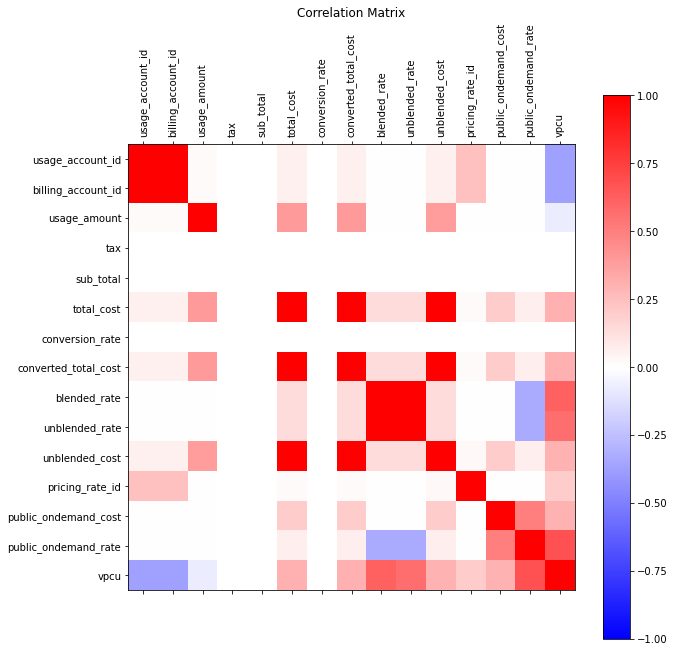

In [13]:
plot_corr(dfTotal)

It looks like there's some light correlation to usage and the vcpu count... nothing too useful, although we may need to make another correlation matrix after some data augmentation. Next, let's look at the %NaN for each column to see which columns are generally unused in the dataset.

In [14]:
dfTotal.isna().sum() / dfTotal.shape[0]

cloud_resource_id       0.003146
usage_account_id        0.000000
billing_account_id      0.000000
provider_code           0.000000
usage_amount            0.000000
currency_code           0.000000
tax                     0.000000
sub_total               0.000000
total_cost              0.000000
system_currency_code    0.000000
conversion_rate         0.000000
converted_total_cost    0.000000
product_name            0.000000
service_code            0.084868
service_name            0.084906
product_sku             0.000605
availability_zone       0.995690
location_id             0.000605
usage_type              0.084868
usage_type_group        0.989718
cost_type               0.000000
instance_type           0.996030
blended_rate            0.000000
unblended_rate          0.000000
unblended_cost          0.000000
category                0.000000
clock_speed             0.996988
from_location           0.577076
to_location             0.577076
transfer_type           0.577076
pricing_ra

It looks like the 3 columns for transfers all need one another to exist. Then, the columns like "instance_type", "volume_type", and "operating_system" all likely point towards the amount of line items that are actual VMs that have been spun up rather than associated costs or abstracted cloud services. It could perhaps be possible to use the amount of rows we have for each of those columns as advisors of fixed costs as certain server instances such as domain controllers, FTP servers, and application servers require high availability.

In [25]:
dfPYCO.sort_values("total_cost", ascending=False)[["invoice_month", "product_name", "total_cost"]]

,invoice_month,product_name,total_cost
65279,2019-09-01,Amazon Elastic Compute Cloud,3284.000000
28934,2019-09-01,AWS Support (Business),1000.000000
96649,2019-10-01,AWS Support (Business),1000.000000
114403,2019-10-01,Amazon Elastic File System,879.020880
29088,2019-09-01,Amazon Elastic File System,861.036975
...,...,...,...
567528,2019-12-01,Amazon Elastic Compute Cloud,-3.050000
96842,2019-10-01,Amazon Elastic Compute Cloud,-100.000000
28932,2019-09-01,AWS Support (Business),-130.774159
96648,2019-10-01,AWS Support (Business),-708.380000


Here, we see some interesting behaviour where it looks like there were certain charges put forward that then had to be fixed.

____
## Plotting
Now, let's make some figures to get an idea of how the big hitter services are affecting costs month over month.

TypeError: Index(...) must be called with a collection of some kind, 'XCO Amazon Elastic Compute Cloud' was passed

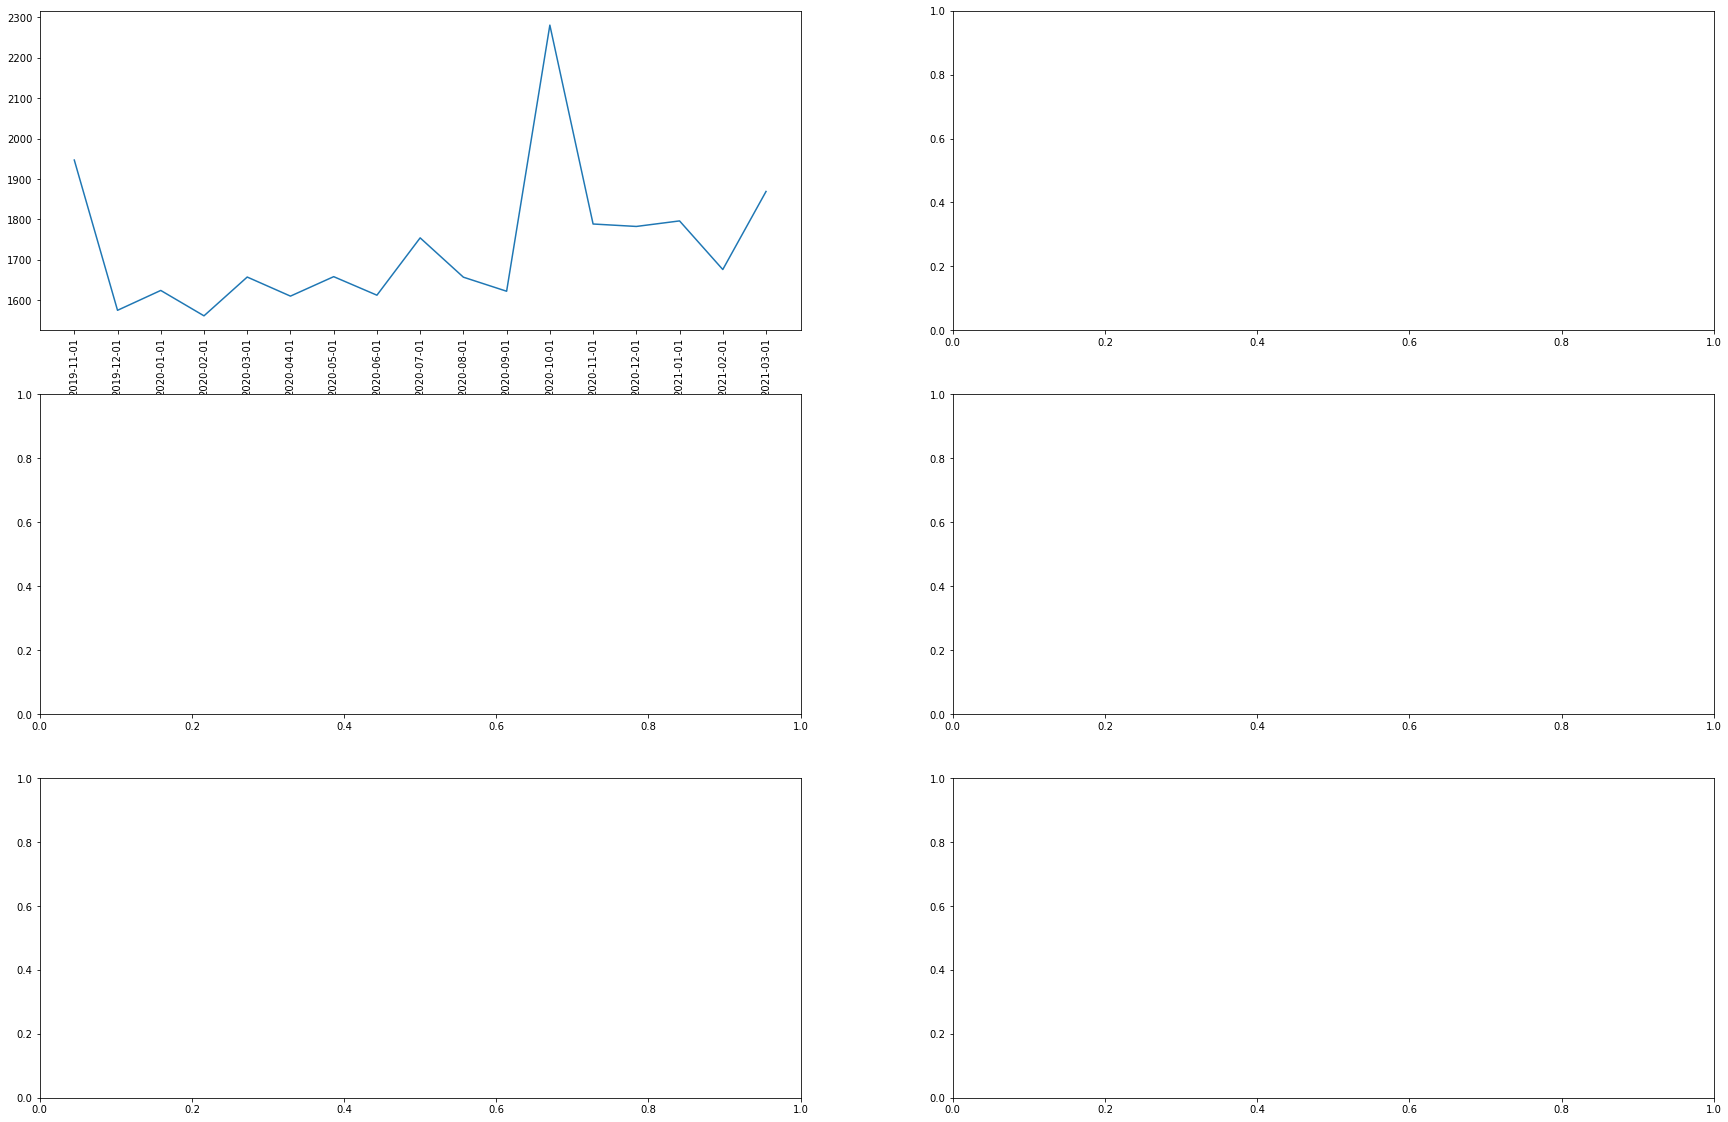

In [38]:
top_5 = plot_n_hitters(5)

In [32]:
top_5[0][0]

,total_cost
invoice_month,
2019-11-01,1946.738957
2019-12-01,1574.961385
2020-01-01,1624.137510
2020-02-01,1561.310425
2020-03-01,1657.272233
2020-04-01,1610.059995
2020-05-01,1658.223858
2020-06-01,1612.355284
2020-07-01,1754.198742


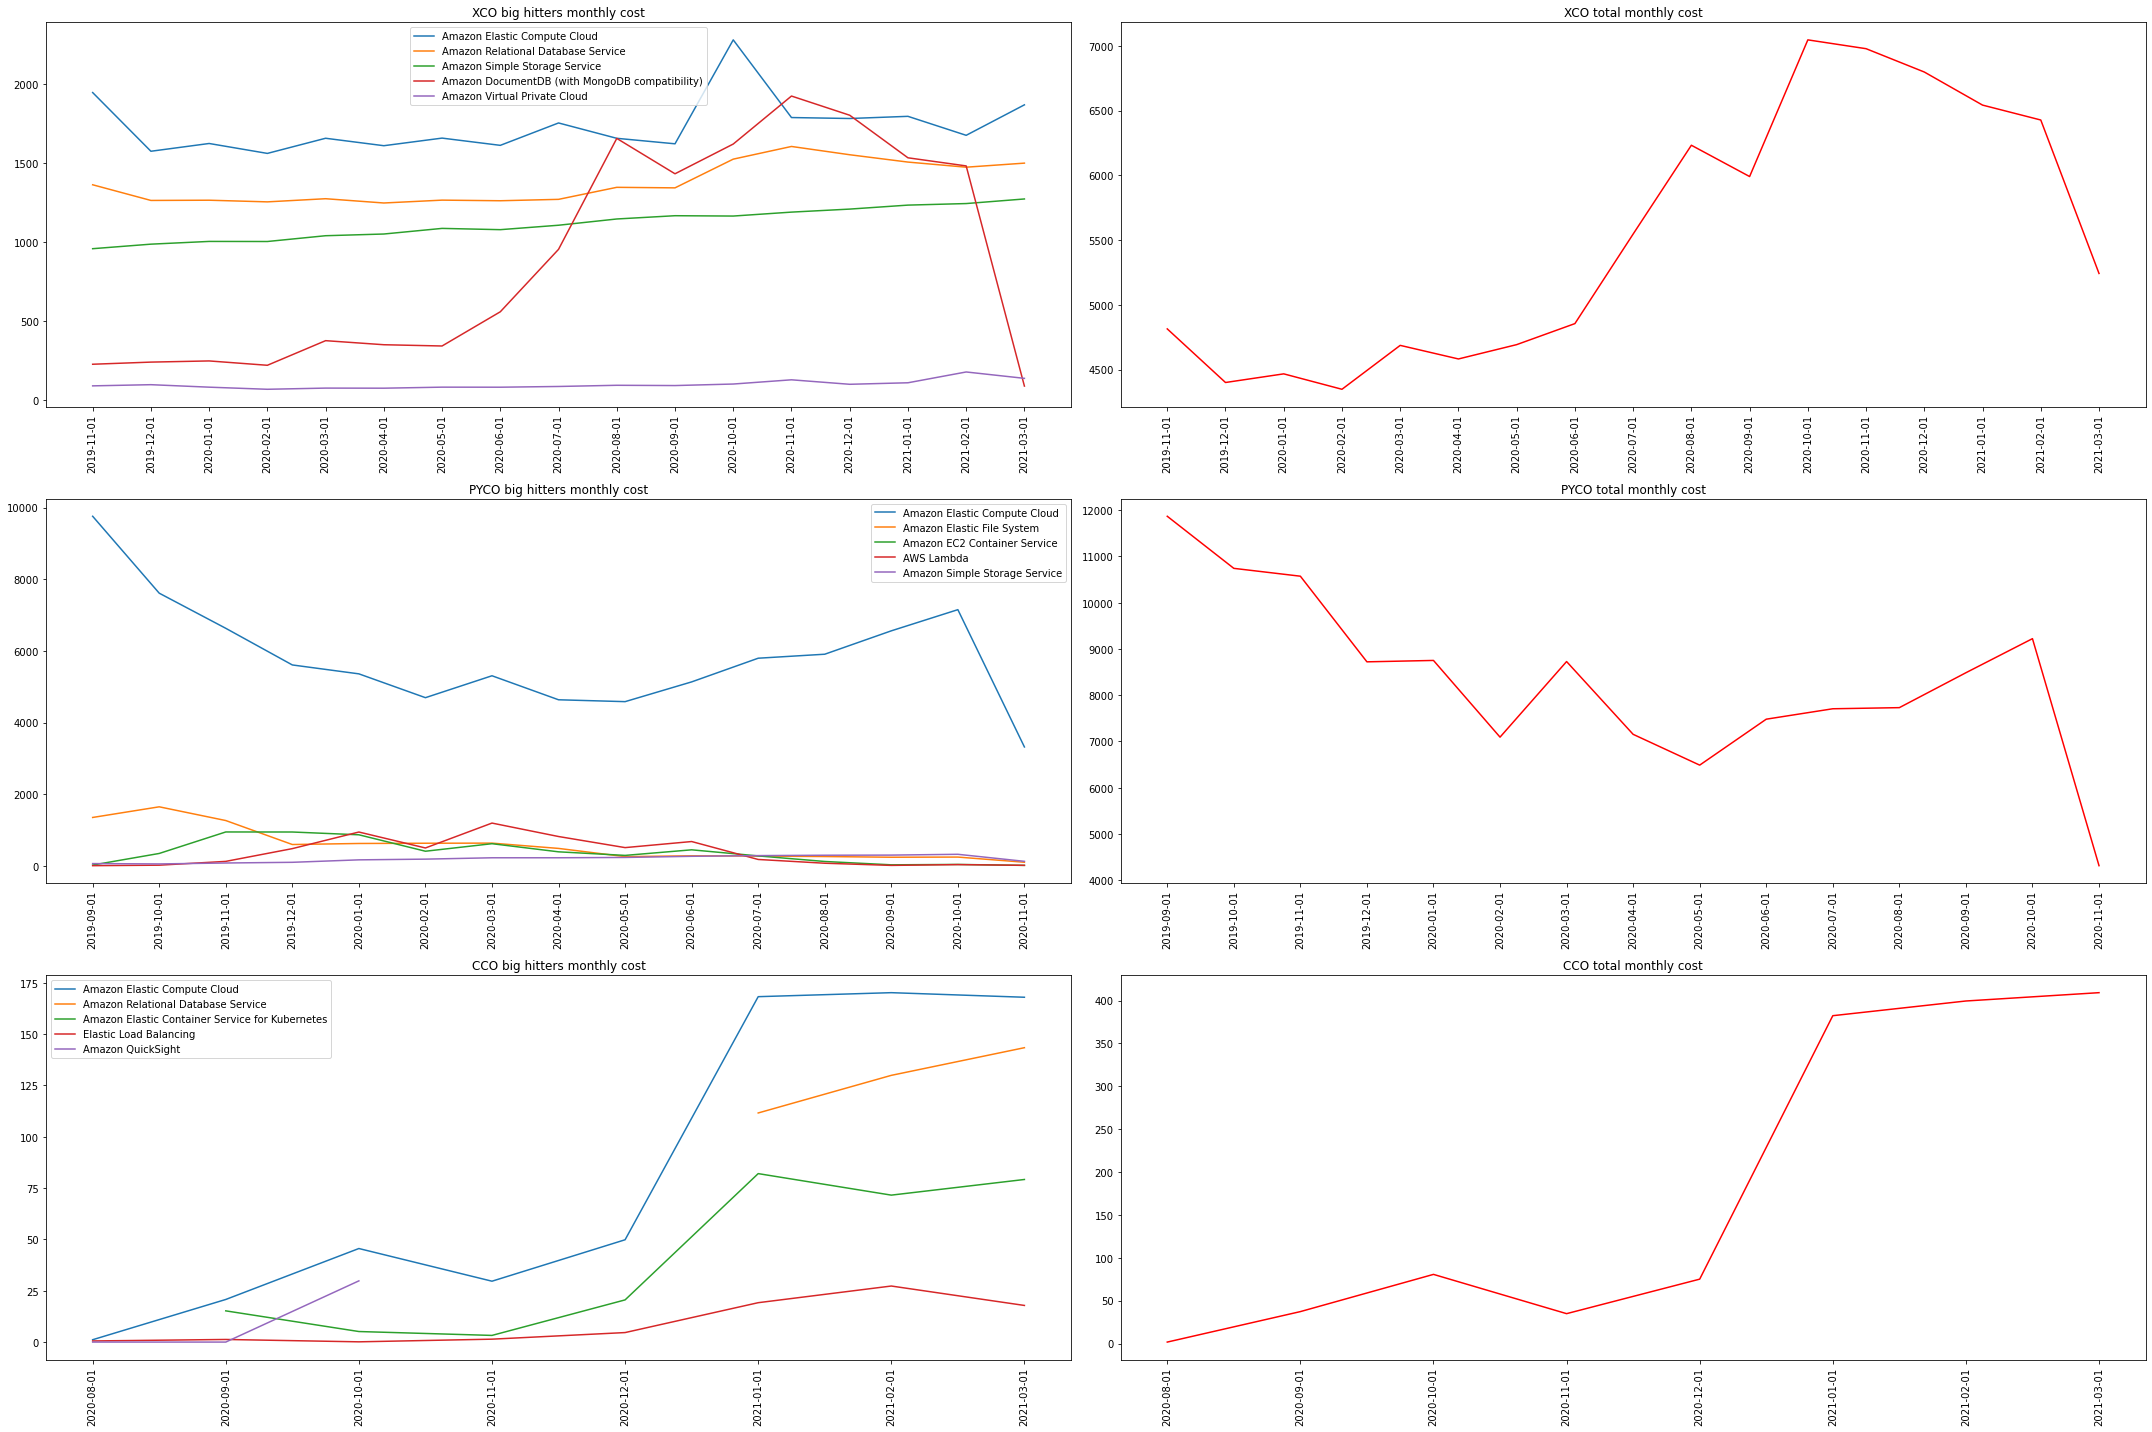

In [20]:
plot_n_hitters_bycorp(5)